Load necessary packages

In [1]:
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cmocean

plt.style.use("thesis")

Define 2D buoyancy perturbation field as $\theta=\sin x$

In [2]:
Re, Ri0, Pr = 5e3, 1, 1

nx = 512
ny = 512

xvec = 2*np.pi*np.arange(nx)/ny
yvec = 2*np.pi*np.arange(ny)/ny

TH = np.zeros((nx,ny))
for j in range(ny):
    TH[:,j] = np.sin(xvec)

Compute and plot sorted profile $Z_*(b)$

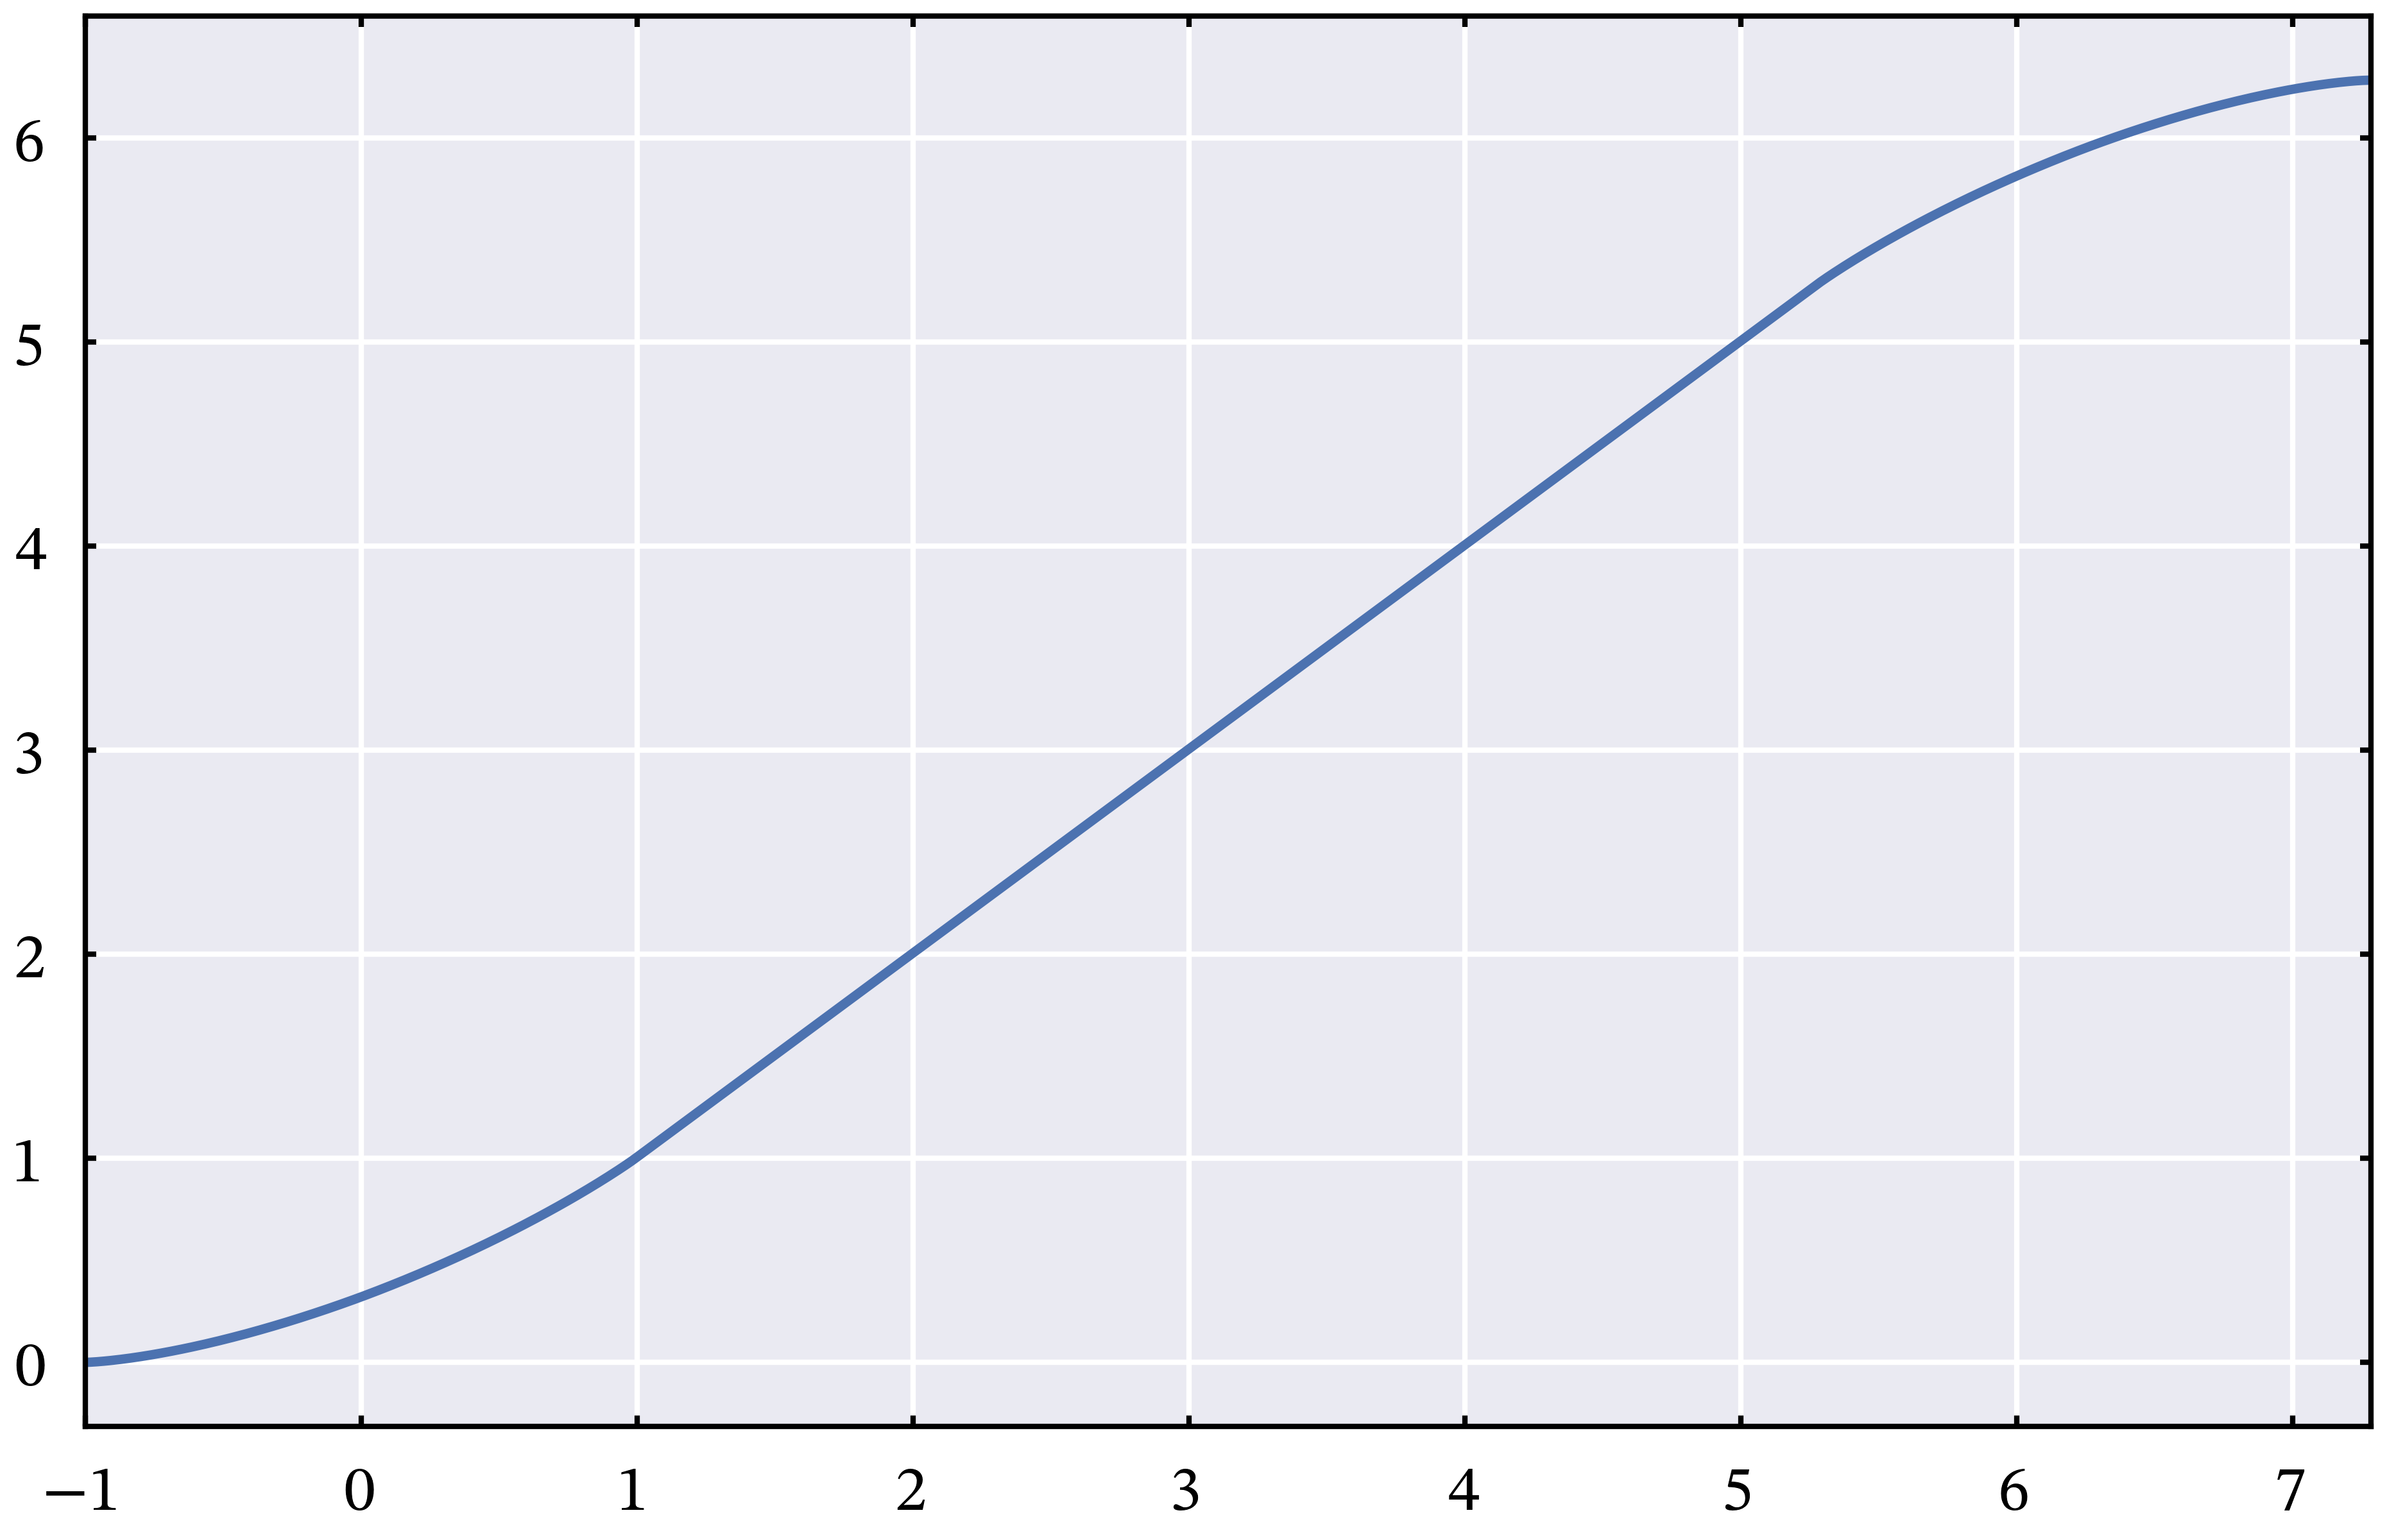

In [3]:
xnum = 128
bw = 2*np.pi/ny
svec = (np.arange(ny + 2*xnum + 1) - xnum)*bw
H, edges = np.histogram((yvec + TH).flatten(), bins=svec)
H = H/bw/np.sum(H)

z_r = np.zeros(svec.size)
for j in range(svec.size):
    z_r[j] = 2*np.pi*bw*np.sum(H[:j])
    
plt.plot(svec,z_r)
plt.xlim([-1,2*np.pi+1])
plt.show()

Compute and plot the gradient $dZ_*/db$

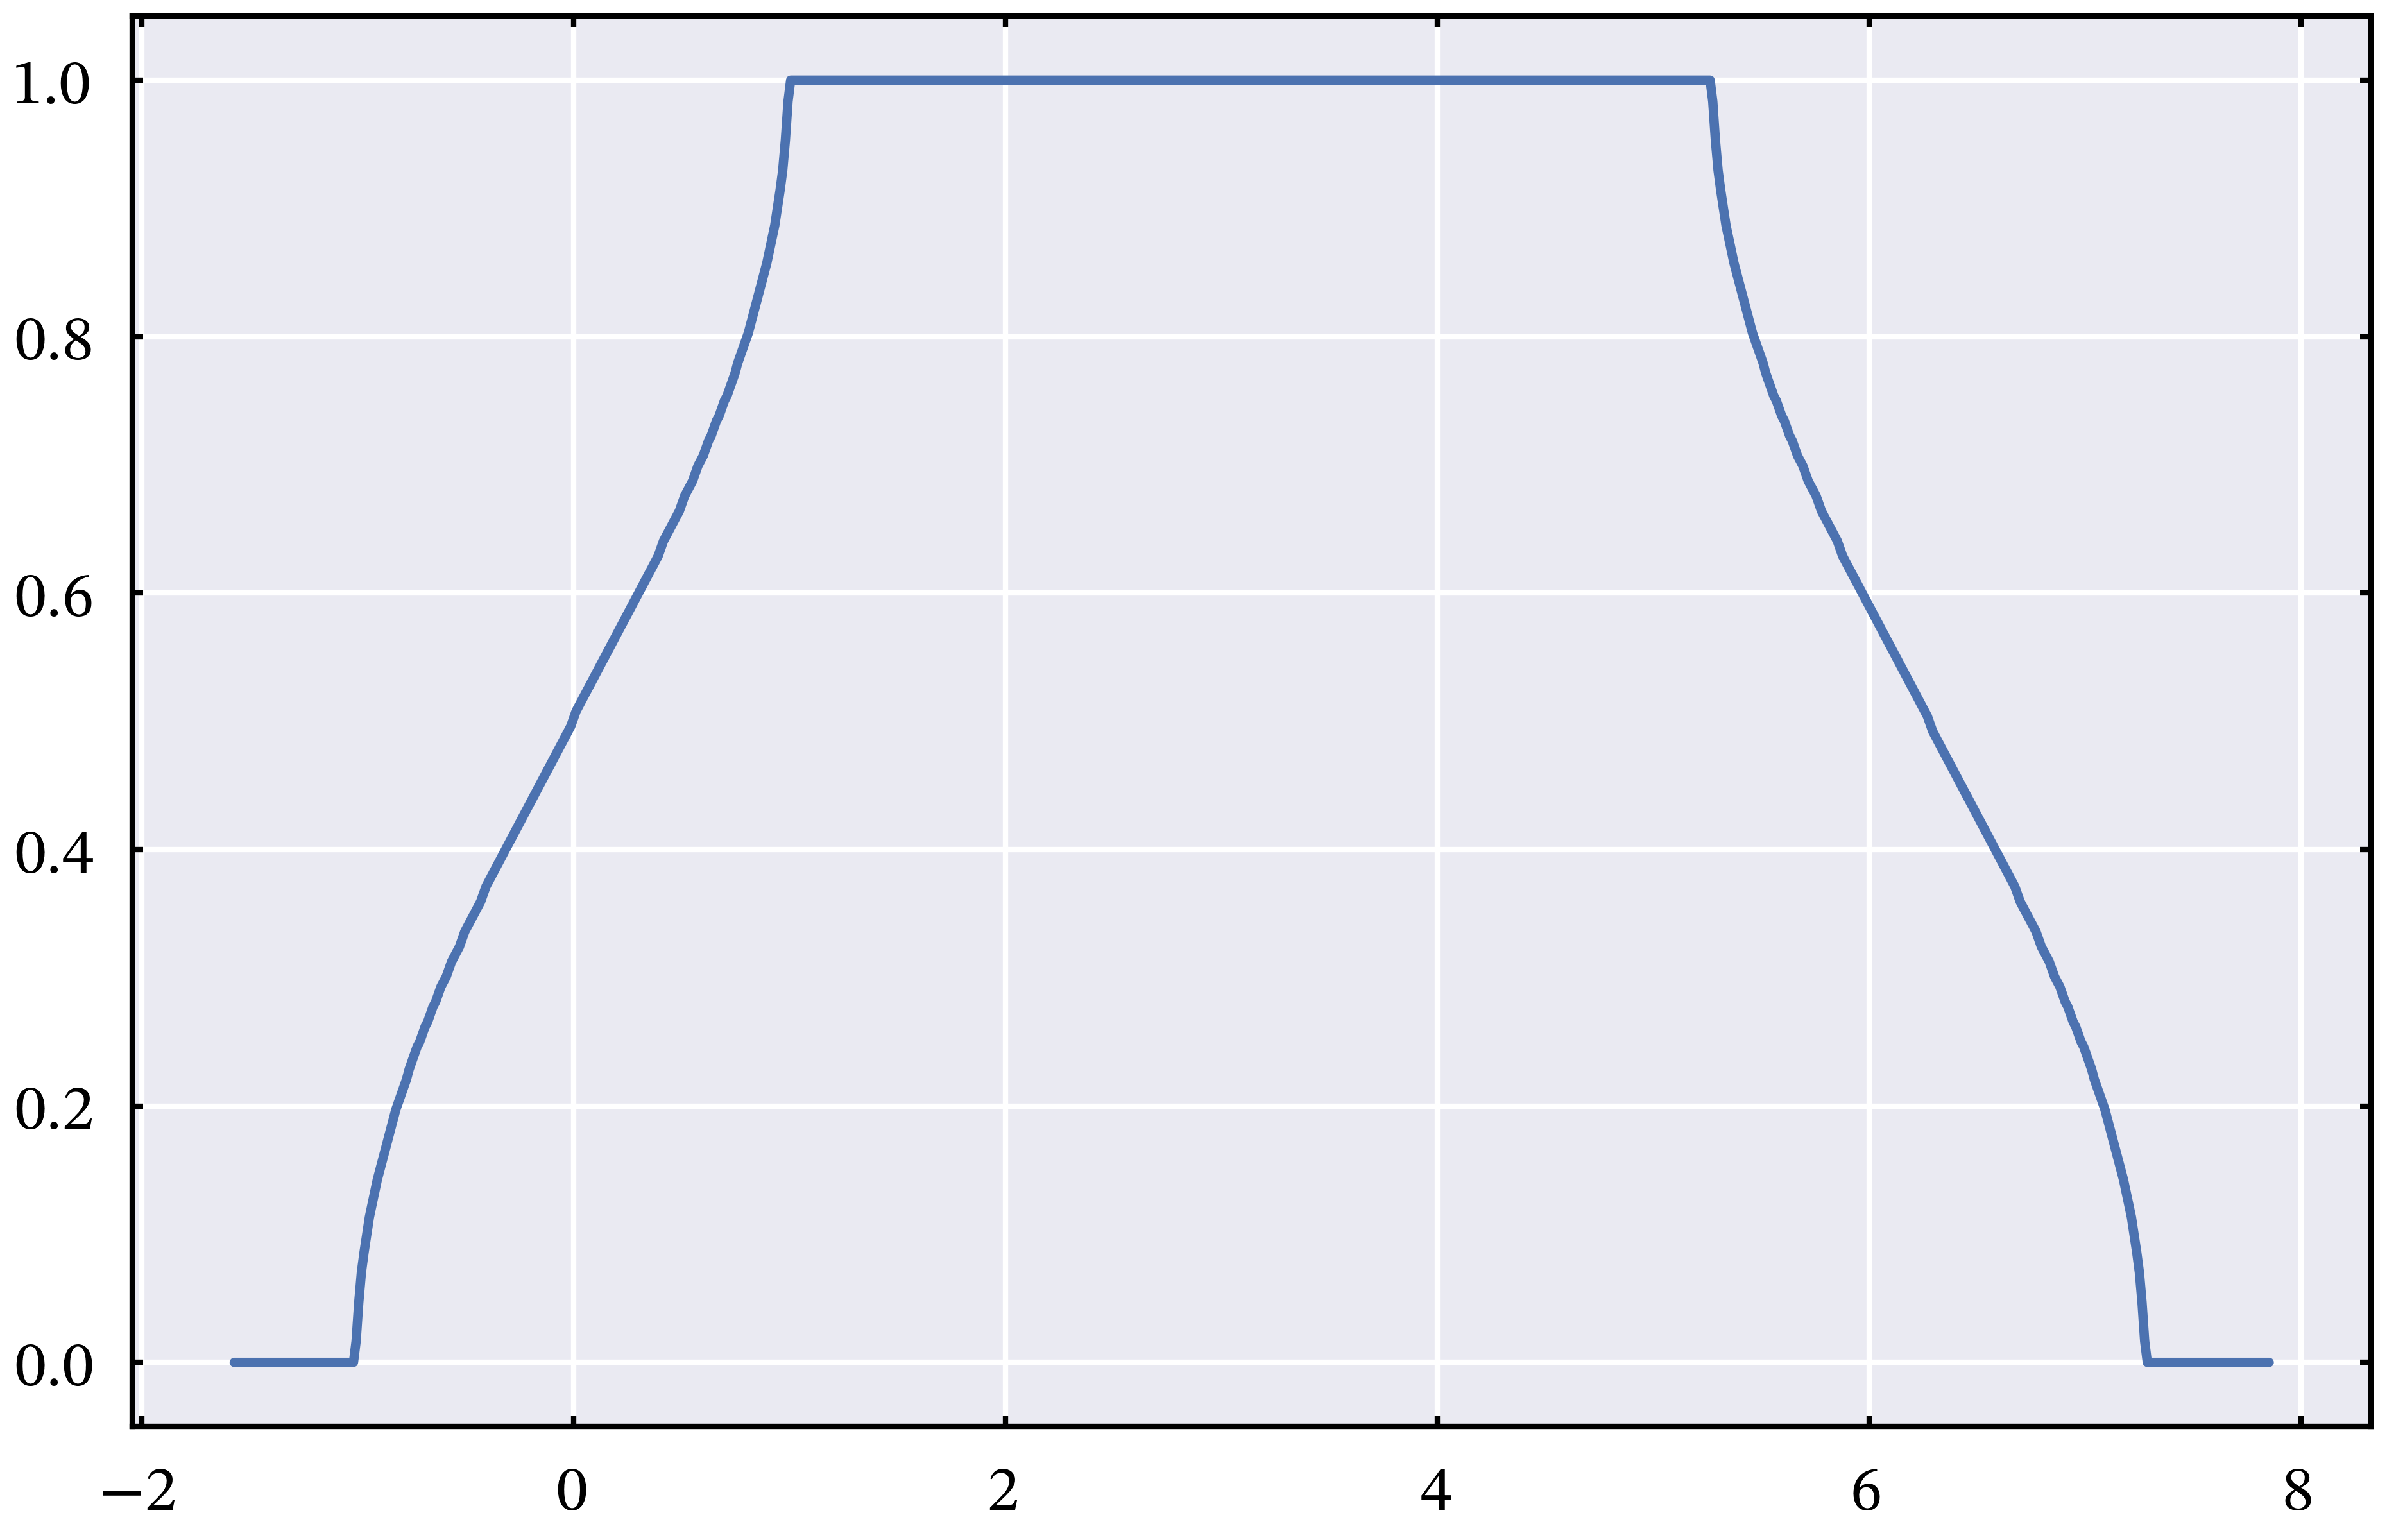

In [4]:
dzdb = np.zeros(z_r.size)
dzdb[1:-1] = (z_r[2:]-z_r[:-2])/(svec[2:]-svec[:-2])
plt.plot(svec,dzdb)
plt.show()

Use FFTs to define derivatives in each direction

In [5]:
import numpy.fft as ft
def dds(S1):
    CS1 = ft.rfft(S1)
    CIKS = 1j*ft.rfftfreq(S1.size, d=1/S1.size)
    CS1 = CIKS*CS1
    return ft.irfft(CS1)

def ddx(S1):
    CS1 = ft.rfft(S1, axis=0)
    CIKX = 1j*ft.rfftfreq(S1.shape[0], d=1/S1.shape[0])
    CIKX = np.reshape(CIKX, (CIKX.size,1))
#     print(CIKX)
    CS1 = CIKX*CS1
    return ft.irfft(CS1, axis=0)

def ddy(S1):
    CS1 = ft.rfft(S1, axis=1)
    CIKY = 1j*ft.rfftfreq(S1.shape[1], d=1/S1.shape[1])
    CS1 = CIKY*CS1
    return ft.irfft(CS1, axis=1)

Compute $\left|\nabla b\right|^2 = |\nabla (z+\theta)|^2$

In [6]:
gradB2 = ddx(TH)**2 + (1 + ddy(TH))**2

Compute local values of $dZ_*/db$

In [7]:
B = yvec + TH
dzdB = np.interp(B, svec, dzdb)

Define functions for figure corner annotations

In [8]:
def anno_tl(ax, str):
    l, r = ax.get_xlim()
    b, t = ax.get_ylim()
    ax.annotate(str, (l, t), xytext=(3, -3), textcoords="offset points", ha='left', va='top')
    return

def anno_tr(ax, str):
    l, r = ax.get_xlim()
    b, t = ax.get_ylim()
    ax.annotate(str, (r, t), xytext=(-3, -3), textcoords="offset points", ha='right', va='top')
    return

## Plot figure 1

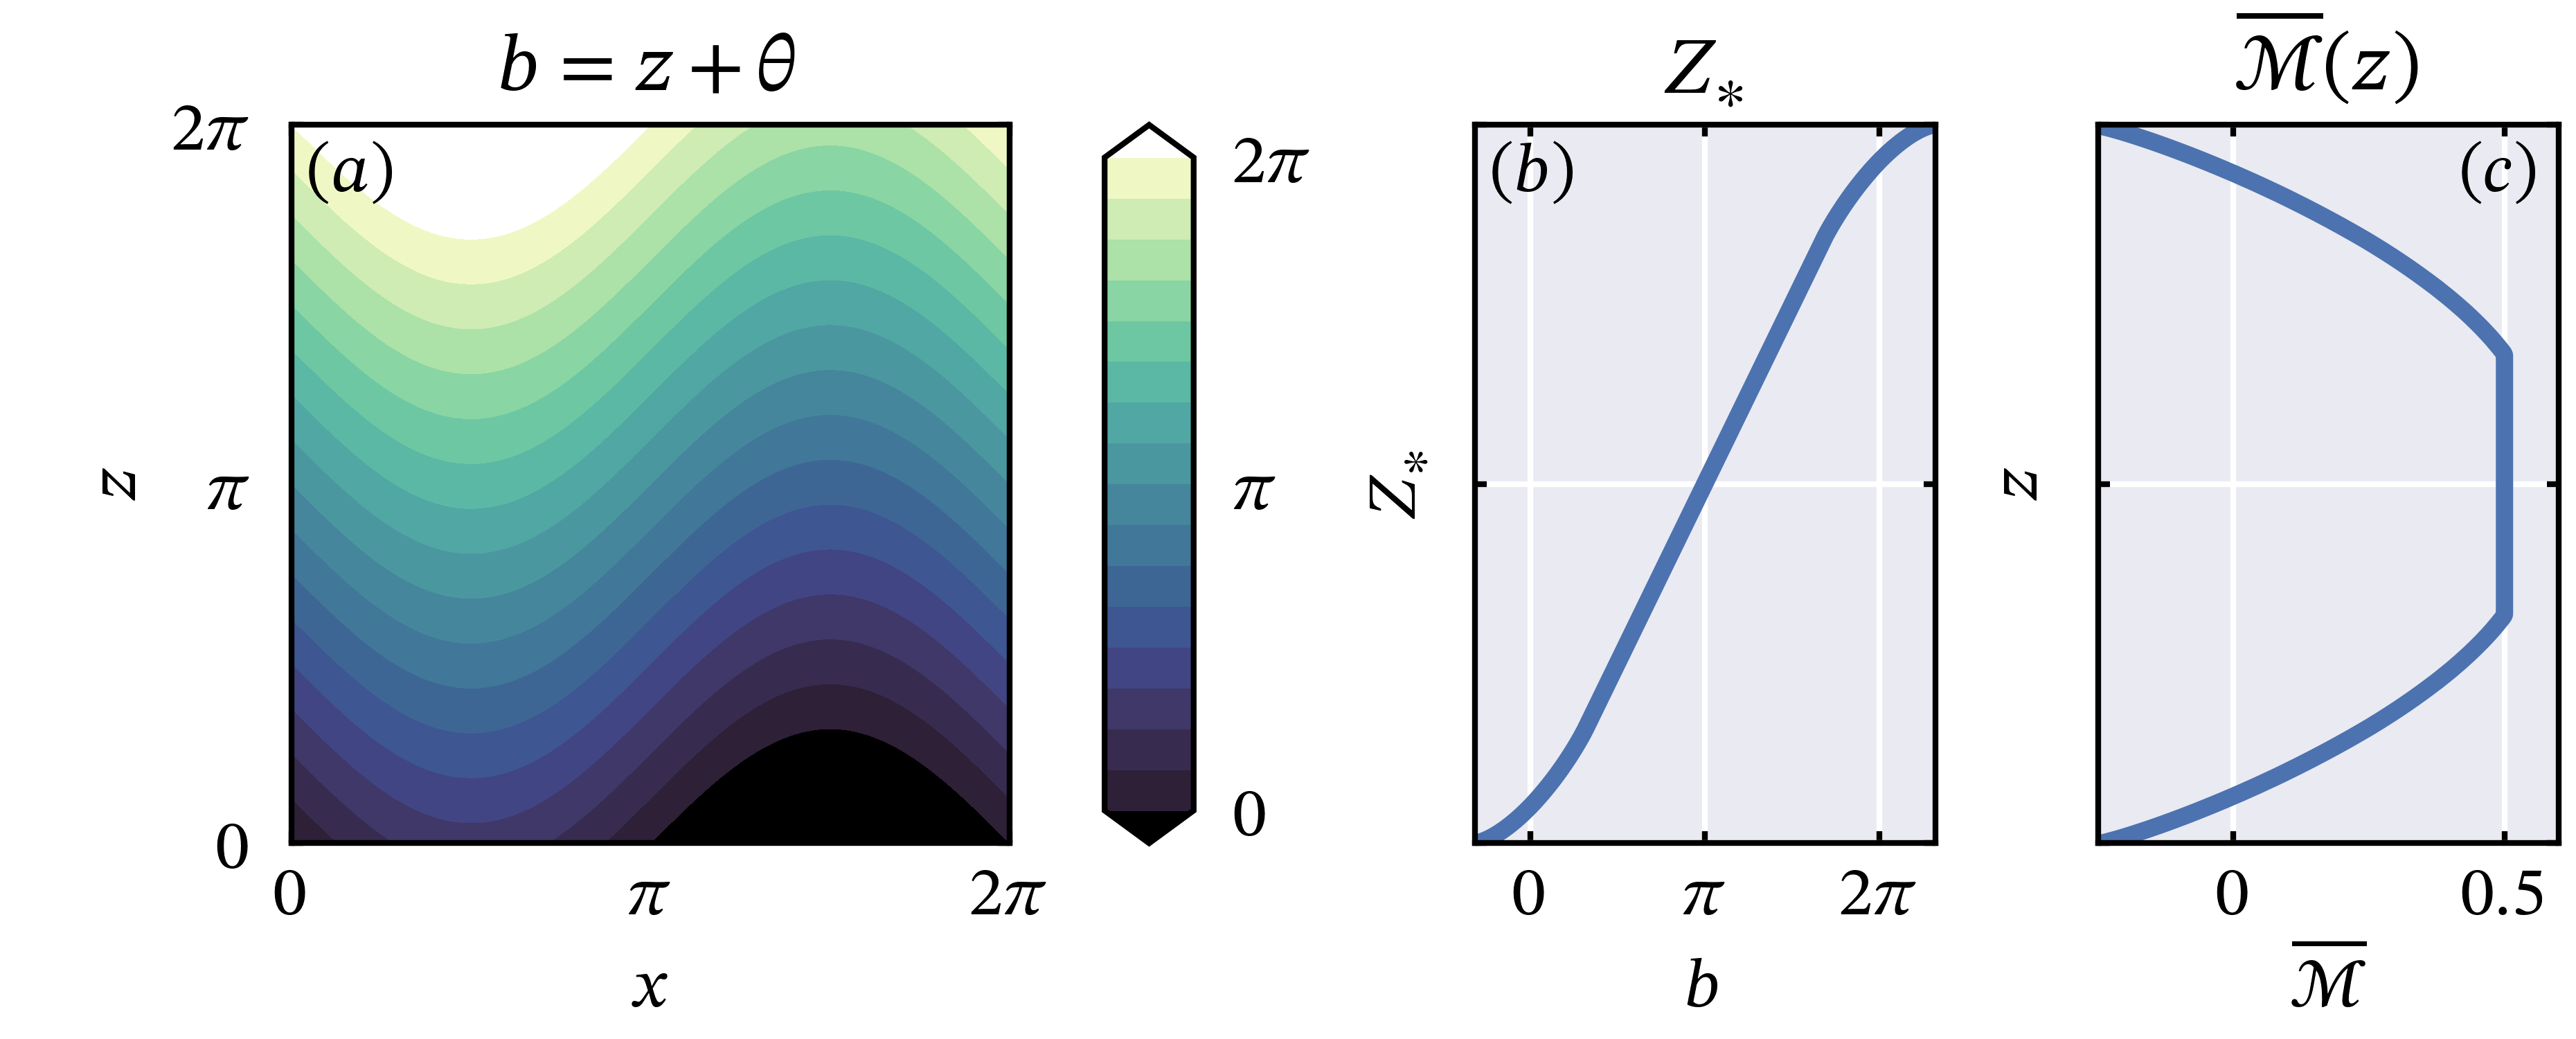

In [9]:
fig, ax = plt.subplots(1,3,figsize=(6.2,2.5),gridspec_kw={'width_ratios': [2, 1, 1]}, sharey=True)
cmap=cmocean.cm.deep_r
cmap.set_over('w')
cmap.set_under('k')
CT = ax[0].contourf(yvec,yvec,(yvec+TH).T,levels=np.arange(17)*np.pi/8,cmap=cmap,extend='both')
ax[0].set(
    title = "$b=z+\\theta$",
    aspect='equal',
    ylabel="$z$",
    xlabel="$x$",
    xticks=np.arange(3)*np.pi,
    yticks=np.arange(3)*np.pi,
    yticklabels=("$0$","$\pi$","$2\pi$")
)
ax[0].set_xticklabels(("$0$","$\pi$","$2\pi$"), va="center_baseline")
ax[0].tick_params(axis='x', pad=8)
ax[0].set_xlabel("$x$", labelpad=16, va="bottom")
cb = fig.colorbar(CT,ax=ax[0])
# cb.outline.set_edgecolor('black')
cb.set_ticks(np.arange(3)*np.pi)
cb.ax.set_yticklabels(("$0$","$\pi$","$2\pi$"))

ax[1].plot(svec,z_r, lw=3)
ax[1].set(
#     aspect=np.pi/2,
    xlim = [-1, 2*np.pi + 1],
    ylim=[0,2*np.pi],
    xlabel="$b$",
    title="$Z_\\ast$",
    xticks=np.arange(3)*np.pi,
    yticks=np.arange(3)*np.pi,
    yticklabels=("$0$","$\pi$","$2\pi$"),
    ylabel="$Z_\\ast$"
)
ax[1].set_xticklabels(("$0$","$\pi$","$2\pi$"), va="center_baseline")
ax[1].tick_params(axis='x', pad=8)
ax[1].set_xlabel("$b$", labelpad=16, va="bottom")
ax[1].set_ylabel("$Z_\\ast$",labelpad=8)

ax[2].plot(np.mean(gradB2*dzdB, axis=0) - 1, yvec, lw=3)
ax[2].set(
    xlim = [-0.25, 0.6],
    ylim = [0, 2*np.pi],
    xlabel = r"$\overline{\mathcal{M}}$",
    title = r"$\overline{\mathcal{M}}(z) $",
    yticks=np.arange(3)*np.pi,
    yticklabels=("$0$","$\pi$","$2\pi$"),
    xticks = [0, 0.5],
    xticklabels = ("$0$", "$0.5$"),
    ylabel="$z$"
)
ax[2].set_xticklabels(("$0$","$0.5$"), va="center_baseline")
ax[2].tick_params(axis='x', pad=8)
ax[2].set_xlabel(r"$\overline{\mathcal{M}}$", labelpad=16, va="bottom")
ax[2].set_ylabel("$z$", labelpad=8)

anno_tl(ax[0], "$(a)$")
anno_tl(ax[1], "$(b)$")
anno_tr(ax[2], "$(c)$")

# plt.savefig("EPS/winters_problem.eps")
# plt.savefig("presentation/winters_problem.svg")

plt.show()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(6.2,2.5),gridspec_kw={'width_ratios': [2, 1, 1]}, sharey=True)
cmap=cmocean.cm.deep_r
cmap.set_over('w')
cmap.set_under('k')
CT = ax[0].contourf(yvec,yvec,np.mod((yvec+TH).T,2*np.pi),levels=np.arange(17)*np.pi/8,cmap=cmap)
ax[0].contour(yvec,yvec,(yvec+TH).T, levels=[0, 2*np.pi], colors='r')
ax[0].set(
    title = "$b=z+\\theta$",
    aspect='equal',
    ylabel="$z$",
    xlabel="$x$",
    xticks=np.arange(3)*np.pi,
    yticks=np.arange(3)*np.pi,
    yticklabels=("$0$","$\pi$","$2\pi$")
)
ax[0].set_xticklabels(("$0$","$\pi$","$2\pi$"), va="center_baseline")
ax[0].tick_params(axis='x', pad=8)
ax[0].set_xlabel("$x$", labelpad=16, va="bottom")
cb = fig.colorbar(CT,ax=ax[0])
# cb.outline.set_edgecolor('black')
cb.set_ticks(np.arange(3)*np.pi)
cb.ax.set_yticklabels(("$0$","$\pi$","$2\pi$"))

ax[1].plot(svec,svec, lw=3)
ax[1].set(
#     aspect=np.pi/2,
    xlim = [-1, 2*np.pi + 1],
    ylim=[0,2*np.pi],
    xlabel="$b$",
    title="$Z_\\ast$",
    xticks=np.arange(3)*np.pi,
    yticks=np.arange(3)*np.pi,
    yticklabels=("$0$","$\pi$","$2\pi$"),
    ylabel="$Z_\\ast$"
)
ax[1].set_xticklabels(("$0$","$\pi$","$2\pi$"), va="center_baseline")
ax[1].tick_params(axis='x', pad=8)
ax[1].set_xlabel("$b$", labelpad=16, va="bottom")
ax[1].set_ylabel("$Z_\\ast$",labelpad=8)

ax[2].plot(np.ones(yvec.size)*0.5, yvec, lw=3)
ax[2].set(
    xlim = [-0.25, 0.6],
    ylim = [0, 2*np.pi],
    xlabel = r"$\overline{\mathcal{M}}$",
    title = r"$\overline{\mathcal{M}}(z) $",
    yticks=np.arange(3)*np.pi,
    yticklabels=("$0$","$\pi$","$2\pi$"),
    xticks = [0, 0.5],
    xticklabels = ("$0$", "$0.5$"),
    ylabel="$z$"
)
ax[2].set_xticklabels(("$0$","$0.5$"), va="center_baseline")
ax[2].tick_params(axis='x', pad=8)
ax[2].set_xlabel(r"$\overline{\mathcal{M}}$", labelpad=16, va="bottom")
ax[2].set_ylabel("$z$", labelpad=8)

# anno_tl(ax[0], "$(a)$")
# anno_tl(ax[1], "$(b)$")
# anno_tr(ax[2], "$(c)$")

# plt.savefig("winters_problem.pdf")
# plt.savefig("presentation/winters_solution.svg")

plt.show()